In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import imageio
from torch import nn
%matplotlib inline

## Problem definition
Suppose we have a time series P(t). P(t) is the solution of a differential equation $$ \frac{dP}{dt} = f(t,P(t))$$ We don't know the differential equation, nor the solution-time series P(t). We have some points (ti, pi) but not P(t). 

## time series - sine data


Let's suppose a simple example, P(t) = sint, which is solution of diff.eq P'(t) = cost. 
##### We pretend like we don't know P(t), just some points (ti,pi), specifically we have 100 points in (-4,4).

# First approach :
One first approach is to approximate P(t) with interpolation, for example a Neural Network. We can use also other models like splines. Neural Network is a continues function approximator with great results, for this reason is a good choice. 

#### model for P(t) approximation
is nn.Sequential with 200 neurons in hidden layer, it's the same with model 1 but written in other way:

In [2]:
#net2 is the network that approximates the time series P(t)
net2 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 1),
    )
optimizer = torch.optim.Adam(net2.parameters(), lr=0.1)
loss_func = torch.nn.MSELoss() 

In [3]:
x = torch.unsqueeze(torch.linspace(-5, 5, 100), dim=1) 

y = torch.sin(x)

tensor(0.7910, grad_fn=<MseLossBackward0>)
tensor(0.6053, grad_fn=<MseLossBackward0>)
tensor(0.6698, grad_fn=<MseLossBackward0>)
tensor(0.5910, grad_fn=<MseLossBackward0>)
tensor(0.5266, grad_fn=<MseLossBackward0>)
tensor(0.5443, grad_fn=<MseLossBackward0>)
tensor(0.5732, grad_fn=<MseLossBackward0>)
tensor(0.5546, grad_fn=<MseLossBackward0>)
tensor(0.5156, grad_fn=<MseLossBackward0>)
tensor(0.4966, grad_fn=<MseLossBackward0>)
tensor(0.5010, grad_fn=<MseLossBackward0>)
tensor(0.5074, grad_fn=<MseLossBackward0>)
tensor(0.4985, grad_fn=<MseLossBackward0>)
tensor(0.4753, grad_fn=<MseLossBackward0>)
tensor(0.4504, grad_fn=<MseLossBackward0>)
tensor(0.4342, grad_fn=<MseLossBackward0>)
tensor(0.4271, grad_fn=<MseLossBackward0>)
tensor(0.4208, grad_fn=<MseLossBackward0>)
tensor(0.4080, grad_fn=<MseLossBackward0>)
tensor(0.3889, grad_fn=<MseLossBackward0>)
tensor(0.3690, grad_fn=<MseLossBackward0>)
tensor(0.3524, grad_fn=<MseLossBackward0>)
tensor(0.3378, grad_fn=<MseLossBackward0>)
tensor(0.32

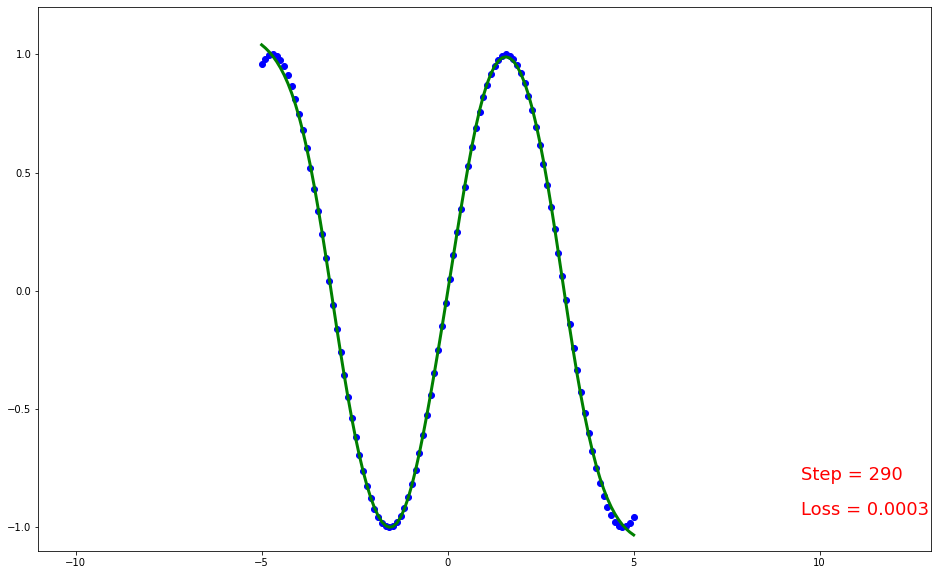

In [4]:
#training
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
losses=[]
for t in range(300):
  
    prediction = net2(x)     

    loss = loss_func(prediction, y) 
    losses.append(loss)
    print(loss)

    optimizer.zero_grad()   
    loss.backward()         
    optimizer.step()        
    
    if t % 10 == 0:
        
        plt.cla()
        ax.set_xlim(-11.0, 13.0)
        ax.set_ylim(-1.1, 1.2)
        ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
        ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
        ax.text(9.50, -0.8, 'Step = %d' % t, fontdict={'size': 18, 'color':  'red'})
        ax.text(9.50, -0.95, 'Loss = %.4f' % loss.data.numpy(),
                fontdict={'size': 18, 'color':  'red'})

        
        fig.canvas.draw()       
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        my_images.append(image)
    
    


imageio.mimsave('./curve_2_bignet.gif', my_images, fps=10)

In [5]:
#we want to store the model that we train!
torch.save(net2.state_dict(),"net_sinx.pth")
print("model trained and stored at net_six.pth")

model trained and stored at net_six.pth


In [5]:
len(y)

100

In [6]:
loss_func(prediction,y)

tensor(0.0003, grad_fn=<MseLossBackward0>)

In [7]:
loss_func(net2(x), y)

tensor(0.0003, grad_fn=<MseLossBackward0>)

### Make predictions

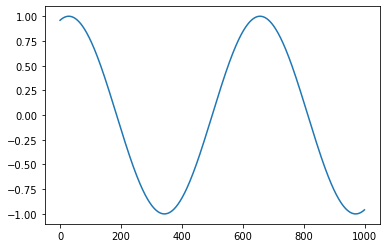

In [11]:
x = torch.unsqueeze(torch.linspace(-5, 5, 1000), dim=1)  #1000 points, so 900 new points

y = torch.sin(x)
x, y = Variable(x), Variable(y)
plt.plot(y)

In [12]:
pred = net2(x)
loss = loss_func(pred, y)
loss 

tensor(0.0003, grad_fn=<MseLossBackward0>)

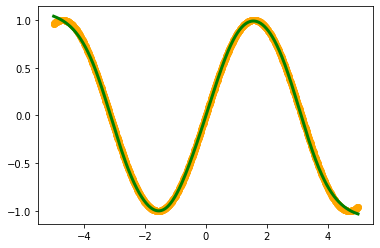

In [13]:
fig, ax = plt.subplots()
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), pred.data.numpy(), 'g-', lw=3)

We can see that we trained the model in 100 points with t in T=(-5,5) and it works very good also for 1000 points in T. We have now an approximator of time series P(t). Although, if we try the model out of T, we see that it works good for data in T, but it's very bad for data out of T! So, it is not reliable for future predictions of time t:

tensor(0.1691, grad_fn=<MseLossBackward0>)


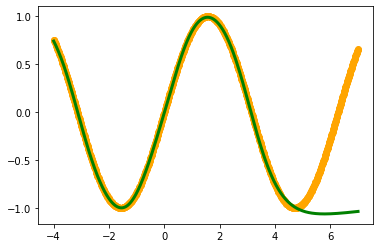

In [14]:
x = torch.unsqueeze(torch.linspace(-4, 7, 800), dim=1) #OUT OF T
y = torch.sin(x)
pred = net2(x)
loss = loss_func(pred, y)
print(loss)
fig, ax = plt.subplots()
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), pred.data.numpy(), 'g-', lw=3)


In [14]:
d= net2(x)-y 
d=d.detach().numpy()
abs(np.mean(d)) #out of T

0.28168342

# Second approach:
One second approach is to use the approximation of P(t) that we found(i.e the avove Neural Network), so P(t) = N(t). Also,
1. As we said, Neural Network is a continues approximator, so we can have the derivative $\frac{dN}{dt}$
2. P(t) = N(t) is the solution of a diff. eq. $$\frac{dP}{dt} = f(t,P(t))$$ which we don't know.
3. suppose $$\frac{dP}{dt} = N1(t) * N(t)$$ where N1(t) is an other Neural Network that we have to train.
4. We want to minimize the loss function $$ E= \frac{1}{2}[\frac{dN}{dt} - N1(t)N(t)]^{2} $$ 


In [15]:
net1 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 1),
    )
#net1 = net1.float() 
#net1 is the network that is trained to find the O.D.E ----> N1(t)

In [16]:
def loss(x):

    x.requires_grad = True
    N = net2(x)
    dN_dx = torch.autograd.grad(N, x, grad_outputs=torch.ones_like(N),
                        create_graph=True)[0]

    return  torch.mean( ( dN_dx - net1(x)*net2(x) )  ** 2)

In [17]:
optimizer = torch.optim.Adam(net1.parameters(), lr=0.001)

x = torch.Tensor(np.linspace(-5, 5, 100)[:, None]) 


In [18]:
losses=[]

In [67]:
def closure():
    
    l = loss(x)
    losses.append(l)
    
    optimizer.zero_grad()
    l.backward()
    print(f"loss: {l}")
    return l

for i in range(6000):
    optimizer.step(closure)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
loss: 0.008873244747519493
loss: 0.008873241022229195
loss: 0.008873182348906994
loss: 0.008873078972101212
loss: 0.008873026818037033
loss: 0.00887303426861763
loss: 0.008872989565134048
loss: 0.00887293741106987
loss: 0.00887283869087696
loss: 0.0088728042319417
loss: 0.008872770704329014
loss: 0.00887263473123312
loss: 0.008872621692717075
loss: 0.008872544392943382
loss: 0.008872484788298607
loss: 0.008872469887137413
loss: 0.008872345089912415
loss: 0.008872389793395996
loss: 0.008872291073203087
loss: 0.008872210048139095
loss: 0.008872158825397491
loss: 0.008872131817042828
loss: 0.008872035890817642
loss: 0.008871972560882568
loss: 0.008871946483850479
loss: 0.008871925994753838
loss: 0.008871820755302906
loss: 0.008871782571077347
loss: 0.008871760219335556
loss: 0.00887166429311037
loss: 0.008871638216078281
loss: 0.008871503174304962
loss: 0.00887148454785347
loss: 0.008871444500982761
loss: 0.008871377445757389
loss: 0.

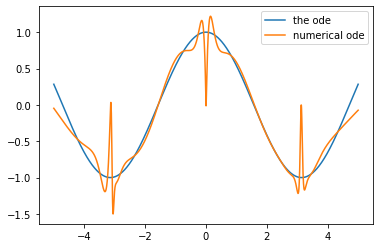

In [88]:
#check if cos is the same with O.D.E
x = torch.unsqueeze(torch.linspace(-5,5, 2000), dim=1) 

dy = torch.cos(x)
method_dy = net1(x)*net2(x)
method_dy = method_dy.detach().numpy()
plt.plot(x,dy, label = 'the ode')
plt.plot(x,method_dy, label ='numerical ode')
plt.legend()
plt.show()

### Step 2: solution of diff.eq.
We have $$\frac{dP}{dt}= N1(t)*N(t) = f(t, P(t))$$ , we can solve this diff. eq with a Neural Network(numericaly) or with any other numerical way.

In [ ]:
#(0,10) 
#t0 --- > net(t0) = A
#sigmoid
#less hidden neurons

In [76]:
x = torch.Tensor(np.linspace(-4, 4, 100)[:, None]) 

In [77]:
NN = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1))
A =net2(x[0])
Psi_t = lambda x: A + (x+4)*NN(x) #NN is responsible for the solution of O.D.E
f = lambda x: net1(x)*net2(x) #they are both trained. 

In [78]:
def loss_fun(x):

    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                        create_graph=True)[0]

    return  torch.mean( ( Psi_t_x - f(x) )  ** 2)

In [79]:
optimizer = torch.optim.Adam(NN.parameters(), lr=0.01)

In [80]:
losses_N=[]

In [82]:
def closure():

    optimizer.zero_grad()
    l = loss_fun(x)
    losses_N.append(l)
    print(l)
    #l.backward()
    l.backward(retain_graph=True)
    return l

for i in range(1000):
    optimizer.step(closure)

tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)


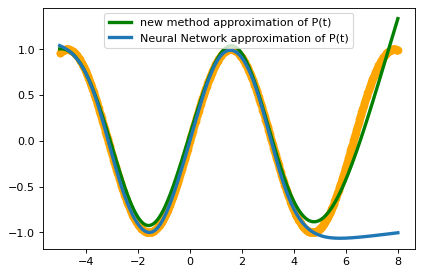

In [100]:
x = torch.unsqueeze(torch.linspace(-5, 8, 800), dim=1) 
y = torch.sin(x)  
p_t_second = Psi_t(x)
p_t_first = net2(x)
fig, ax = plt.subplots(dpi=80)
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), p_t_second.data.numpy(), 'g-', lw=3, label ='new method approximation of P(t)')
ax.plot(x.data.numpy(), p_t_first.data.numpy(), lw=3, label ='Neural Network approximation of P(t)')
#ax.plot(x.data.numpy(), yrk, lw=3, label ='RK approximation of P(t)')

plt.legend(loc='best');

# Solution of O.D.E with RK method:
I have the O.D.E $$ \frac{dy}{dt} = N1(t)*N(t) = f(t,y(t)) ,y =p(t)$$
The RK methods is:  
1. $$ k1 = f(tn,yn) = N1(tn)*N(tn) $$
2. $$ k2 = f(tn+\frac{h}{2}, yn+h\frac{k1}{2}) = N1(tn+\frac{h}{2})* N(tn+\frac{h}{2})$$
3. $$ k3 = f(tn+\frac{h}{2}, yn+h\frac{k2}{2}) = N1(tn+\frac{h}{2})* N(tn+\frac{h}{2})$$
4. $$ k4 = f(tn+h, yn+hk3) = N1(tn+h)* N(tn+h) $$
So, $$y^{n+1} = y^{n} +\frac{1}{6}(k1+2k2+2k3+k4)$$

In [90]:
x = torch.unsqueeze(torch.linspace(-5,5, 2000), dim=1) 
N = len(x)
h = (5+5)/N

In [91]:
y = torch.sin(x)

In [92]:
yrk = np.zeros(int(N))
yrk[0]=net2(x[0])
for i in range(0,int(N-1)):
    k1 = net1(x[i])*net2(x[i])
    k2 = net1(x[i]+(h/2))*net2(x[i]+(h/2))
    k3 = net1(x[i]+(h/2))*net2(x[i]+(h/2))
    k4 = net1(x[i]+h)*net2(x[i]+h)

    yrk[i+1] = yrk[i] + (1/6)*h*(k1+2*k2+2*k3+k4)

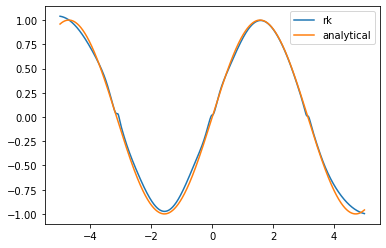

In [93]:
plt.plot(x,yrk, label ='rk')
plt.plot(x,y, label ='analytical')

plt.legend()
plt.show()

In [94]:
y_num = y.detach().numpy()
abs(np.mean(y_num-yrk))

0.01760672148456797



```
# Αυτό έχει τη μορφή κώδικα
```

**Change of range of T:**

In [96]:
x = torch.unsqueeze(torch.linspace(-5,8, 2000), dim=1) 
N = len(x)
h = (8+5)/N

In [97]:
#analytical
y = torch.sin(x) 
#rk
yrk = np.zeros(int(N))
yrk[0]=net2(x[0])
#yrk[0]=y[0]
for i in range(0,int(N-1)):
    k1 = net1(x[i])*net2(x[i])
    k2 = net1(x[i]+(h/2))*net2(x[i]+(h/2))
    k3 = net1(x[i]+(h/2))*net2(x[i]+(h/2))
    k4 = net1(x[i]+h)*net2(x[i]+h)

    yrk[i+1] = yrk[i] + (1/6)*h*(k1+2*k2+2*k3+k4)

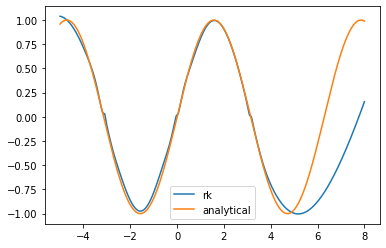

In [98]:
plt.plot(x,yrk, label ='rk')
plt.plot(x,y, label ='analytical')
plt.legend()
plt.show()